# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print( 'Train data shape: ', X_train.shape)
print( 'Train labels shape: ', y_train.shape)
print( 'Validation data shape: ', X_val.shape)
print( 'Validation labels shape: ', y_val.shape)
print( 'Test data shape: ', X_test.shape)
print( 'Test labels shape: ', y_test.shape)
print( 'dev data shape: ', X_dev.shape)
print( 'dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print( 'loss: %f' % loss)
print( 'sanity check: %f' % (-np.log(0.1)))

loss: 2.374939
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [25]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.652975 analytic: 0.652975, relative error: 1.000000e+00
numerical: -0.188282 analytic: 0.188282, relative error: 1.000000e+00
numerical: 0.040962 analytic: -0.040962, relative error: 1.000000e+00
numerical: 0.384974 analytic: -0.384974, relative error: 1.000000e+00
numerical: -1.739533 analytic: 1.739533, relative error: 1.000000e+00
numerical: -6.243234 analytic: 6.243234, relative error: 1.000000e+00
numerical: 0.960635 analytic: -0.960635, relative error: 1.000000e+00
numerical: 0.738841 analytic: -0.738841, relative error: 1.000000e+00
numerical: 1.371528 analytic: -1.371528, relative error: 1.000000e+00
numerical: 1.427974 analytic: -1.427974, relative error: 1.000000e+00
numerical: 0.881785 analytic: -0.838979, relative error: 1.000000e+00
numerical: 1.307778 analytic: -1.294458, relative error: 1.000000e+00
numerical: -2.075822 analytic: 2.031153, relative error: 1.000000e+00
numerical: -1.422427 analytic: 1.445121, relative error: 1.000000e+00
numerical: -1.992806

In [30]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print( 'naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print( 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print( 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print( 'Gradient difference: %f' % grad_difference)

naive loss: 2.373656e+00 computed in 0.468739s
[[ 0.07451632  0.12093111  0.14046382 ...,  0.08718157  0.04219207
   0.07564283]
 [ 0.0958739   0.110622    0.05326094 ...,  0.06373946  0.11177794
   0.10336354]
 [ 0.08494333  0.1292555   0.10189338 ...,  0.09876849  0.1321308
   0.09153963]
 ..., 
 [ 0.18394004  0.05828789  0.09826463 ...,  0.09838528  0.19973374
   0.0736339 ]
 [ 0.11252308  0.04273064  0.03656785 ...,  0.08286723  0.25298893
   0.03620912]
 [ 0.08851328  0.10214637  0.10769653 ...,  0.07360303  0.10900965
   0.07515714]]
vectorized loss: 2.373656e+00 computed in 0.031247s
Loss difference: 0.000000
Gradient difference: 0.000000


In [5]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = np.logspace(-10, 10, 10) #[1e-7, 5e-7]
regularization_strengths =  np.logspace(-3, 6, 10) #[1e3, 5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=rs,
                              num_iters=500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        tracc = (np.mean(y_train == y_train_pred))
        print( 'training accuracy: %f' % tracc)
        y_val_pred = softmax.predict(X_val)
        valacc = np.mean(y_val == y_val_pred)
        print( 'validation accuracy: %f' % valacc )
        results[(lr,rs)]=(tracc, valacc)
        if(best_val < valacc):
            best_val = valacc
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print( 'best validation accuracy achieved during cross-validation: %f' % best_val)
#lr 2.782559e-06 reg 1.000000e+03 train accuracy: 0.385122 val accuracy: 0.386000

iteration 0 / 500: loss 14.161184
iteration 100 / 500: loss 13.756142
iteration 200 / 500: loss 14.929032
iteration 300 / 500: loss 13.237215
iteration 400 / 500: loss 16.418276
training accuracy: 0.108265
validation accuracy: 0.112000
iteration 0 / 500: loss 14.608902
iteration 100 / 500: loss 15.410476
iteration 200 / 500: loss 14.714609
iteration 300 / 500: loss 16.423372
iteration 400 / 500: loss 16.661257
training accuracy: 0.103510
validation accuracy: 0.111000
iteration 0 / 500: loss 14.938471
iteration 100 / 500: loss 12.800420
iteration 200 / 500: loss 13.182932
iteration 300 / 500: loss 14.925286
iteration 400 / 500: loss 14.165889
training accuracy: 0.099531
validation accuracy: 0.104000
iteration 0 / 500: loss 12.769135
iteration 100 / 500: loss 14.386530
iteration 200 / 500: loss 13.888326
iteration 300 / 500: loss 14.325208
iteration 400 / 500: loss 13.508679
training accuracy: 0.104122
validation accuracy: 0.102000
iteration 0 / 500: loss 13.253587
iteration 100 / 500: l

D:\Personal Work\Kaggle\winter1516_assignment1\assignment1\cs231n\classifiers\softmax.py:89: RuntimeWarning: divide by zero encountered in log
  loss=np.mean(-np.log( np.exp(z_correct)/np.sum(np.exp(z)) ))
D:\Personal Work\Kaggle\winter1516_assignment1\assignment1\cs231n\classifiers\softmax.py:93: RuntimeWarning: invalid value encountered in true_divide
  z/=np.sum(z,axis=1).reshape(N,1)


training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 500: loss 14.976081
[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]] 2
[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 500: loss 15.515998
[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]] 2
[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  

In [6]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print ('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.369000


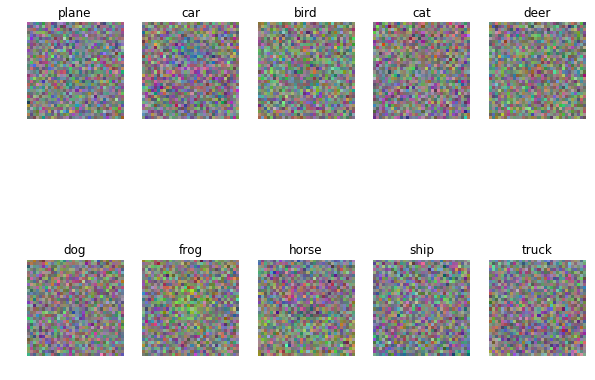

In [7]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])